In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from io import StringIO
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
import csv
import re
from collections import Counter
from ipykernel import kernelapp as app

np.set_printoptions(threshold=np.inf)

#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [ ]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

In [ ]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

def Tanh(x):
    x[x<=0] = -1
    x[x>0] = 1
    return x

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

class dlnet:
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [26, 38, 15, 1] 
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.2
        self.sam = self.Y.shape[1]
        self.threshold=0.5
        self.alpha = 0.01
        self.lambda_value = 0.006
        self.m = self.X.shape[0]
        
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1)) 
        self.param['W3'] = np.random.randn(self.dims[3], self.dims[2]) / np.sqrt(self.dims[2])
        self.param['b3'] = np.zeros((self.dims[3], 1))
        return 

    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Relu(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        Z3 = self.param['W3'].dot(A2) + self.param['b3']
        A3 = Sigmoid(Z3)
        self.ch['Z3'],self.ch['A3']=Z3,A3
        self.Yh=A3
        loss=self.nloss(A3)
        return self.Yh, loss
    
    def forward_test(self):
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Relu(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        Z3 = self.param['W3'].dot(A2) + self.param['b3']
        A3 = Sigmoid(Z3)
        self.Yh=A3
        print("Testing is done")
        #self.nloss(A2)
        return self.Yh

    def nloss(self,Yh):
        l2 = (self.lambda_value / 2 * self.X.shape[1]) * (np.sum(np.square(self.param['W1'])) + np.sum(np.square(self.param['W2'])))
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))  +  l2
        return loss

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z3 = dLoss_Yh * dSigmoid(self.ch['Z3'])
        dLoss_A2 = np.dot(self.param["W3"].T,dLoss_Z3)
        dLoss_Z2 = dLoss_A2 * dRelu(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W3 = 1./self.ch['A2'].shape[1] * np.dot(dLoss_Z3,self.ch['A2'].T) + np.dot(self.lambda_value,self.param["W3"])
        dLoss_b3 = 1./self.ch['A2'].shape[1] * np.dot(dLoss_Z3, np.ones([dLoss_Z3.shape[1],1]))
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T) + np.dot(self.lambda_value,self.param["W2"])
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1]))
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T) + np.dot(self.lambda_value,self.param["W1"])
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))         
        #print(self.X.shape)
        #print(self.Yh.shape)

        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1 
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1  
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        self.param["W3"] = self.param["W3"] - self.lr * dLoss_W3
        self.param["b3"] = self.param["b3"] - self.lr * dLoss_b3
        #W = np.array[W1,W2]
        return


    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
            #loss_v = np.vectorize(loss)
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return 


In [ ]:
from imblearn import under_sampling, over_sampling

In [ ]:
label = []
Peptide = []
with open('train.dat') as f: 
    for line in f:
        peptide = re.sub('\n','', line)
        peptide = re.sub('\t','', peptide)
        #peptide = peptide.lstrip("\t")
        peptide = peptide.strip('1-1')
       # print(Peptide)
        Peptide.append(peptide)
#print(Peptide)
Peptide_list_temp = []
Peptide_list = []
N = len(Peptide)
for i in range(N):
    Peptide_list.append(list(Peptide[i]))
    
new_peptide_list = sum(Peptide_list, [])
peptide_array = np.array(new_peptide_list)
dictionary = np.unique(peptide_array)
print(list(dictionary))
print(len(dictionary))

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
21


In [ ]:
# key, value for all chars in string e.g hashmap['D'] = 2
string = "TLNTVVGSISGAVP"
def peptide_to_feature(string):
    dictionary = ['A','B','C','D','E','F', 'G', 'H', 'I','J', 'K', 'L', 'M', 'N','O', 'P', 'Q', 'R', 'S', 'T', 'U','V',
 'W', 'X', 'Y', 'Z']
    hashmap = dict.fromkeys(dictionary, 0)
    for j in range(len(string)):
        for i in hashmap:
            if i == string[j]:
                hashmap[i] = hashmap[i]+1
    return hashmap

In [ ]:
hashmap0 = (peptide_to_feature(string))
print(hashmap0)
dictionary = ['A','B','C','D','E','F', 'G', 'H', 'I','J', 'K', 'L', 'M', 'N','O', 'P', 'Q', 'R', 'S', 'T', 'U','V',
 'W', 'X', 'Y', 'Z']

{'A': 1, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 2, 'H': 0, 'I': 1, 'J': 0, 'K': 0, 'L': 1, 'M': 0, 'N': 1, 'O': 0, 'P': 1, 'Q': 0, 'R': 0, 'S': 2, 'T': 2, 'U': 0, 'V': 3, 'W': 0, 'X': 0, 'Y': 0, 'Z': 0}


In [ ]:
file = pd.read_csv('train.dat', sep="\t", names=['Label','Peptide'])
#file.insert(0, 'Label')
main_df = pd.DataFrame(file)

In [ ]:
#selected_df = main_df.drop(columns=['Label'])
#main_df = main_df.head(100)
#main_df["Label"].replace(-1, 0, inplace=True)
main_df = main_df.reindex(columns=main_df.columns.tolist() + list(dictionary))
Label_list = main_df['Label'].to_list()
print(main_df)

      Label                                      Peptide   A   B   C   D   E  \
0        -1                              DVELDLVEISPNALP NaN NaN NaN NaN NaN   
1        -1                               KADEELFNKLFFGT NaN NaN NaN NaN NaN   
2        -1  FLVALHLGTAFALLWYFRKRWCALVRGFFASFGGRRNDDAHMM NaN NaN NaN NaN NaN   
3        -1                         RDQMRARIADITGVAISRIA NaN NaN NaN NaN NaN   
4        -1                                    RKRLQLLLL NaN NaN NaN NaN NaN   
...     ...                                          ...  ..  ..  ..  ..  ..   
1561     -1                                    YAQSEGDTG NaN NaN NaN NaN NaN   
1562      1                          FIKHFIHRFGGGRWRWRWF NaN NaN NaN NaN NaN   
1563      1                                   KWKIRVRLSA NaN NaN NaN NaN NaN   
1564     -1                               TLNTVVGSISGAVP NaN NaN NaN NaN NaN   
1565     -1                                        HFRSQ NaN NaN NaN NaN NaN   

       F   G   H  ...   Q   R   S   T  

In [ ]:
N = 1566
for i in range(N):
    string = main_df.at[i, "Peptide"]
    hashmap = peptide_to_feature(string)
    main_df.at[i, list(dictionary)] = list(hashmap.values())
print(main_df)

      Label                                      Peptide    A    B    C    D  \
0        -1                              DVELDLVEISPNALP  1.0  0.0  0.0  2.0   
1        -1                               KADEELFNKLFFGT  1.0  0.0  0.0  1.0   
2        -1  FLVALHLGTAFALLWYFRKRWCALVRGFFASFGGRRNDDAHMM  6.0  0.0  1.0  2.0   
3        -1                         RDQMRARIADITGVAISRIA  4.0  0.0  0.0  2.0   
4        -1                                    RKRLQLLLL  0.0  0.0  0.0  0.0   
...     ...                                          ...  ...  ...  ...  ...   
1561     -1                                    YAQSEGDTG  1.0  0.0  0.0  1.0   
1562      1                          FIKHFIHRFGGGRWRWRWF  0.0  0.0  0.0  0.0   
1563      1                                   KWKIRVRLSA  1.0  0.0  0.0  0.0   
1564     -1                               TLNTVVGSISGAVP  1.0  0.0  0.0  0.0   
1565     -1                                        HFRSQ  0.0  0.0  0.0  0.0   

        E    F    G    H  ...    Q    R

In [ ]:
#names = main_df.columns[list(dictionary)]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(main_df.loc[:, list(dictionary)])
scaled_df = pd.DataFrame(scaled_df, columns=list(dictionary))
print(scaled_df)

             A    B         C      D    E      F    G         H    I    J  \
0     0.071429  0.0  0.000000  0.250  0.2  0.000  0.0  0.000000  0.1  0.0   
1     0.071429  0.0  0.000000  0.125  0.2  0.375  0.1  0.000000  0.0  0.0   
2     0.428571  0.0  0.066667  0.250  0.0  0.750  0.4  0.142857  0.0  0.0   
3     0.285714  0.0  0.000000  0.250  0.0  0.000  0.1  0.000000  0.4  0.0   
4     0.000000  0.0  0.000000  0.000  0.0  0.000  0.0  0.000000  0.0  0.0   
...        ...  ...       ...    ...  ...    ...  ...       ...  ...  ...   
1561  0.071429  0.0  0.000000  0.125  0.1  0.000  0.2  0.000000  0.0  0.0   
1562  0.000000  0.0  0.000000  0.000  0.0  0.500  0.3  0.142857  0.2  0.0   
1563  0.071429  0.0  0.000000  0.000  0.0  0.000  0.0  0.000000  0.1  0.0   
1564  0.071429  0.0  0.000000  0.000  0.0  0.000  0.2  0.000000  0.1  0.0   
1565  0.000000  0.0  0.000000  0.000  0.0  0.125  0.0  0.071429  0.0  0.0   

      ...       Q         R         S         T    U         V         W   

In [ ]:
scaled_df.insert(0, 'Label', Label_list)
print(scaled_df)

      Label         A    B         C      D    E      F    G         H    I  \
0        -1  0.071429  0.0  0.000000  0.250  0.2  0.000  0.0  0.000000  0.1   
1        -1  0.071429  0.0  0.000000  0.125  0.2  0.375  0.1  0.000000  0.0   
2        -1  0.428571  0.0  0.066667  0.250  0.0  0.750  0.4  0.142857  0.0   
3        -1  0.285714  0.0  0.000000  0.250  0.0  0.000  0.1  0.000000  0.4   
4        -1  0.000000  0.0  0.000000  0.000  0.0  0.000  0.0  0.000000  0.0   
...     ...       ...  ...       ...    ...  ...    ...  ...       ...  ...   
1561     -1  0.071429  0.0  0.000000  0.125  0.1  0.000  0.2  0.000000  0.0   
1562      1  0.000000  0.0  0.000000  0.000  0.0  0.500  0.3  0.142857  0.2   
1563      1  0.071429  0.0  0.000000  0.000  0.0  0.000  0.0  0.000000  0.1   
1564     -1  0.071429  0.0  0.000000  0.000  0.0  0.000  0.2  0.000000  0.1   
1565     -1  0.000000  0.0  0.000000  0.000  0.0  0.125  0.0  0.071429  0.0   

      ...       Q         R         S         T    

In [ ]:
pep_anti = scaled_df[scaled_df['Label']==1]
pep_nanti = scaled_df[scaled_df['Label']==0]

In [ ]:
# change main_df to scaled_df to get normalization back 

In [ ]:
print(pep_anti.shape)
print(sorted(Counter(main_df['Label']).items()))
X = main_df
Y = main_df['Label']
X.drop('Label', axis=1, inplace=True)

(142, 27)
[(-1, 1424), (1, 142)]


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, Y)
print(sorted(Counter(y_resampled).items()),y_resampled.shape)
oversampled_df = pd.DataFrame(X_resampled)
oversampled_df.insert(0, 'Label', y_resampled)
#print(y_resampled)
print(oversampled_df)

[(-1, 1424), (1, 1424)] (2848,)
      Label                                      Peptide    A    B    C    D  \
0        -1                              DVELDLVEISPNALP  1.0  0.0  0.0  2.0   
1        -1                               KADEELFNKLFFGT  1.0  0.0  0.0  1.0   
2        -1  FLVALHLGTAFALLWYFRKRWCALVRGFFASFGGRRNDDAHMM  6.0  0.0  1.0  2.0   
3        -1                         RDQMRARIADITGVAISRIA  4.0  0.0  0.0  2.0   
4        -1                                    RKRLQLLLL  0.0  0.0  0.0  0.0   
...     ...                                          ...  ...  ...  ...  ...   
2843      1                             RPAFRKAAFRVMRACV  4.0  0.0  1.0  0.0   
2844      1                    GWGSFFKKAAHVGKHVGKAALTHYL  4.0  0.0  0.0  0.0   
2845      1                                FLGALFKALSKLL  2.0  0.0  0.0  0.0   
2846      1                                     FWRRFWRR  0.0  0.0  0.0  0.0   
2847      1               KSKEKIGKEFKRIVQRIKDFLRNLVPRTES  0.0  0.0  0.0  1.0   

       

In [ ]:
#oversampled_df = oversampled_df.astype(int)

<AxesSubplot:ylabel='Frequency'>

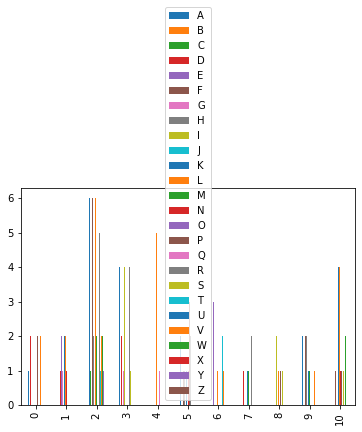

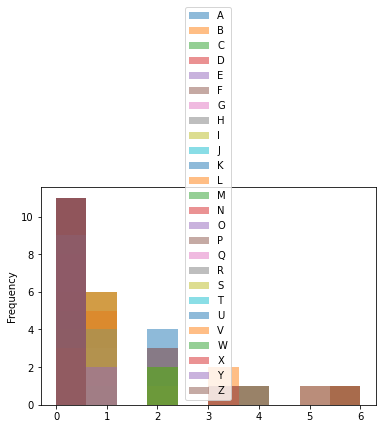

In [ ]:
oversampled_df.loc[0:10, list(dictionary)].plot.bar();
oversampled_df.loc[0:10, list(dictionary)].plot.hist(alpha=0.5)

In [ ]:
x_train = list(oversampled_df.loc[570:2848, list(dictionary)].values)
x_val = list(oversampled_df.loc[0:569, list(dictionary)].values)
y_train = list(oversampled_df.loc[570:2848, 'Label'])
y_val = list(oversampled_df.loc[0:569, 'Label'])

print (type(x_train))
#print (y_train)

x_train = np.array(x_train).astype(int)
x_val = np.array(x_val).astype(int)
x_train = x_train.T
x_val = x_val.T

print(type(x_train))
print(x_val.shape)
print(x_train.shape)
#y_train.shape()

y_train = np.array(y_train).astype(int)
y_val = np.array(y_val).astype(int)
#print(y_val)
y_train = np.where(y_train<0, 0, y_train)
y_val = np.where(y_val<0, 0, y_val)

y_train = np.reshape(y_train,(1,-1))
y_val = np.reshape(y_val,(1,-1))
print(y_train.shape)
print(y_val.shape)

<class 'list'>
<class 'numpy.ndarray'>
(26, 570)
(26, 2278)
(1, 2278)
(1, 570)


In [ ]:
nn = dlnet(x_train,y_train)
nn.lr = 0.07
nn.lambda_value = 0.009
nn.dims = [26, 38, 15, 1]

In [ ]:
nn.gd(x_train, y_train, iter = 45000 )

Cost after iteration 0: 536.888412
Cost after iteration 500: 345.556077
Cost after iteration 1000: 241.618965
Cost after iteration 1500: 188.816626
Cost after iteration 2000: 160.540079
Cost after iteration 2500: 145.071753
Cost after iteration 3000: 136.681267
Cost after iteration 3500: 132.180834
Cost after iteration 4000: 129.882644
Cost after iteration 4500: 128.787367
Cost after iteration 5000: 128.185047
Cost after iteration 5500: 127.836211
Cost after iteration 6000: 127.714287
Cost after iteration 6500: 127.675116
Cost after iteration 7000: 127.630819
Cost after iteration 7500: 127.540020
Cost after iteration 8000: 127.406439
Cost after iteration 8500: 127.212345
Cost after iteration 9000: 127.090181
Cost after iteration 9500: 127.016760
Cost after iteration 10000: 126.990553
Cost after iteration 10500: 126.974435
Cost after iteration 11000: 126.947638
Cost after iteration 11500: 126.943384
Cost after iteration 12000: 126.917471
Cost after iteration 12500: 126.933534
Cost after

In [ ]:
pred_train = nn.pred(x_train, y_train)
pred_test = nn.pred(x_val, y_val)
type(y_val)

Acc: 0.39903424056189635
Acc: 0.8999999999999999


numpy.ndarray

Acc: 0.39903424056189635


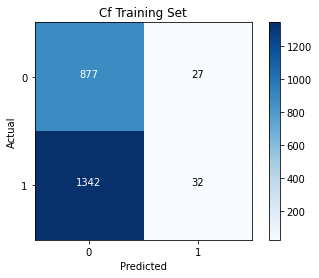

Acc: 0.8999999999999999


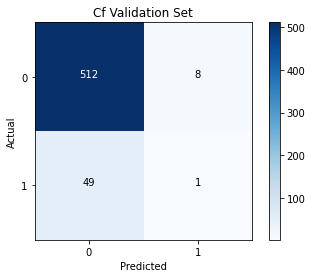

In [ ]:
nn.threshold=0.5

nn.X,nn.Y = x_train, y_train 
target=np.around(np.squeeze(y_train), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x_train,y_train)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=x_val, y_val 
target=np.around(np.squeeze(y_val), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x_val,y_val)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

Acc: 0.9688323090430201


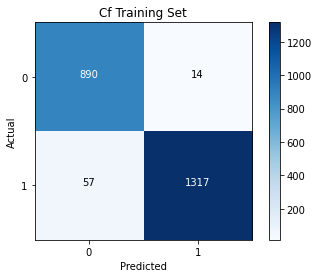

Acc: 0.9719298245614035


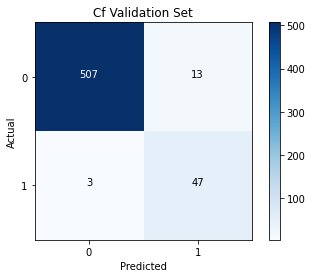

In [ ]:
nn.threshold=0.7

nn.X,nn.Y=x_train, y_train 
target=np.around(np.squeeze(y_train), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x_train,y_train)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=x_val, y_val 
target=np.around(np.squeeze(y_val), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x_val,y_val)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

Acc: 0.9100087796312554


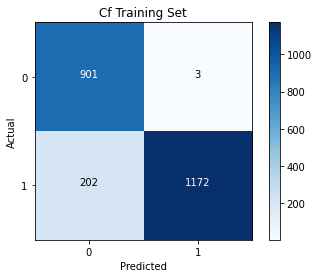

Acc: 0.9771929824561403


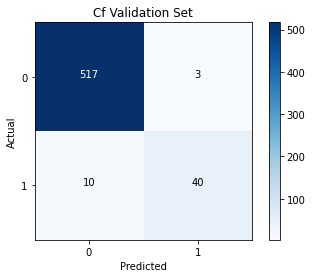

In [ ]:
nn.threshold=0.9

nn.X,nn.Y=x_train, y_train 
target=np.around(np.squeeze(y_train), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x_train,y_train)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=x_val, y_val 
target=np.around(np.squeeze(y_val), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x_val,y_val)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

In [ ]:
nn.X,nn.Y=x_val, y_val 
yvalh, loss = nn.forward()
print("\ny",np.around(y_val[:,0:50,], decimals=0).astype(np.int))       
print("\nyh",np.around(yvalh[:,0:50,], decimals=0).astype(np.int),"\n")         


y [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
  0 1 0 0 0 0 0 0 0 0 1 1 0 0]]

yh [[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0
  0 1 0 0 0 0 0 0 0 0 1 1 0 0]] 



In [ ]:
file = pd.read_csv('test.dat', header=None) #, sep="\t", names=['Label','Peptide'])
#file.insert(0, 'Label')
test_df = pd.DataFrame(file)
#print(test_df)
test_df.columns = ['Peptide']
print(test_df)
test_df = test_df.reindex(columns=test_df.columns.tolist() + list(dictionary))
#print(test_df)

                                           Peptide
0                      KPTNAYEFGQVLSTISARKDEEACAHL
1               FLTAGDPDLETTRQALLALDREGADLIELGVPYS
2                              RIVQRIKDFLRNLVPRTES
3                                  ERWAPARSQAYLGVL
4                           FSFEGRRRALQAQEGIAALRDN
..                                             ...
387     GAYSVQSYEEAFDDGCVVKVAKKVATEATDTRGRDEIRTSCD
388  VISIPPVVEERPDGSKVEVAPEQNFVLINPEIIKASDQEDVGLEG
389     TGHALEFAGSAIRGLSMEGRMTLCNMAIEAGARVGMVAVDEK
390                     AVEVKGPKGVLVTPTHTELNYAVEDG
391                     NSIAKAIKARGEVIHCKLRAMKELSE

[392 rows x 1 columns]


In [ ]:
N = 392
for i in range(N):
    string = test_df.at[i, "Peptide"]
    hashmap = peptide_to_feature(string)
    test_df.at[i, list(dictionary)] = list(hashmap.values())
print(test_df)

                                           Peptide    A    B    C    D    E  \
0                      KPTNAYEFGQVLSTISARKDEEACAHL  4.0  0.0  1.0  1.0  3.0   
1               FLTAGDPDLETTRQALLALDREGADLIELGVPYS  4.0  0.0  0.0  4.0  3.0   
2                              RIVQRIKDFLRNLVPRTES  0.0  0.0  0.0  1.0  1.0   
3                                  ERWAPARSQAYLGVL  3.0  0.0  0.0  0.0  1.0   
4                           FSFEGRRRALQAQEGIAALRDN  4.0  0.0  0.0  1.0  2.0   
..                                             ...  ...  ...  ...  ...  ...   
387     GAYSVQSYEEAFDDGCVVKVAKKVATEATDTRGRDEIRTSCD  5.0  0.0  2.0  5.0  4.0   
388  VISIPPVVEERPDGSKVEVAPEQNFVLINPEIIKASDQEDVGLEG  2.0  0.0  0.0  3.0  7.0   
389     TGHALEFAGSAIRGLSMEGRMTLCNMAIEAGARVGMVAVDEK  7.0  0.0  1.0  1.0  4.0   
390                     AVEVKGPKGVLVTPTHTELNYAVEDG  2.0  0.0  0.0  1.0  3.0   
391                     NSIAKAIKARGEVIHCKLRAMKELSE  4.0  0.0  1.0  0.0  3.0   

       F    G    H    I  ...    Q    R    S    T   

In [ ]:
x_test = list(test_df.loc[0:391, list(dictionary)].values)
#y_test = np.zeros((391,), dtype=int)
x_test = np.array(x_test).astype(int)
x_test = x_test.T
#y_test = np.reshape(y_test,(1,-1))
print(x_test.shape)
#print(y_test.shape)
#y_test = np.array(y_test).astype(int)
#x_train = x_test
#print(type(y_test))

(26, 392)


In [ ]:
nn.X = x_test
y_test = nn.forward_test()
print(y_test.shape)
#print(y_test[0])
y_test = np.around(y_test, decimals=0).astype(np.int)
print(len(y_test[0]))
#print("\ny_test",y_test.item(0))
print(type(y_test))

Testing is done
(1, 392)
392
<class 'numpy.ndarray'>


In [ ]:
file = pd.read_csv('format.dat', names=['Label'])
#file.insert(0, 'Label')
format_df = pd.DataFrame(file)
#format_df.columns = ['Peptide']
#test_df = test_df.reindex(columns=test_df.columns.tolist() + list(dictionary))
print(format_df)

     Label
0       -1
1       -1
2       -1
3       -1
4       -1
..     ...
387      1
388     -1
389      1
390      1
391      1

[392 rows x 1 columns]


In [ ]:
y_format = list(format_df['Label'])
y_format = np.array(y_format)
y_format = np.where(y_format<0, 0, y_format)
print(y_format)

[0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0
 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1
 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1
 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1
 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1
 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1
 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0
 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0
 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1
 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1]


In [ ]:
y_test = np.where(y_test==0, -1, y_test)
y_test = y_test.astype(int)
np.savetxt('prediction.txt', y_test, fmt='%d', delimiter='\n', newline='\n')
file = pd.read_csv('prediction.txt', names=['Label'])
#file = file.astype(int)
print(file)

     Label
0       -1
1       -1
2        1
3       -1
4       -1
..     ...
387     -1
388     -1
389     -1
390     -1
391     -1

[392 rows x 1 columns]


In [ ]:
y_test = np.where(y_test<0, 0, y_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)
nn.X = x_test
nn.Y = y_test
pred_train = nn.pred(x_test, y_test)

(26, 392)
(1, 392)
Acc: 0.9311224489795917
